# Open data reproducibility notebook

We are not permitted to redistribute mutation-annotated trees that include GISAID data (which we analyse in the paper). Therefore, here we provide an alternative version that performs the core year-based analysis using just open data from the INSDC databases (from a more limited range of countries). We have built this version with a new approach using the [Big Tree Explorer](https://github.com/jmcbroome/BTE). We will add open-source versions of further analyses in the future.

In [ ]:
We are very grateful to those who have deposited data in open databases to make this reproducibility possible.

The cell below downloads the tree described in https://academic.oup.com/mbe/article/38/12/5819/6361626

In [46]:
!wget -qN http://hgdownload.soe.ucsc.edu/goldenPath/wuhCor1/UShER_SARS-CoV-2/public-latest.all.masked.pb.gz

In [1]:
import bte

tree = bte.MATree("public-latest.all.masked.pb.gz")

Finished 'from_pb' in 38.8013 seconds


In [ ]:
#translations = tree.translate("/mnt/d/cov.gtf", "/mnt/d/ref.fasta")


In [2]:
num_descendants = {}
for node in tree.depth_first_expansion(reverse=True):
    if node.is_leaf():
        num_descendants[node.id] = 1
    else:
        num_descendants[node.id] = sum(num_descendants[child.id]
                                       for child in node.children)


In [36]:
# create a TextIO object to write to
import io
outputs = io.StringIO()

import re
from collections import Counter


def mut_to_class(s):
    # A123G becomes A>G
    return re.sub(r"(\w)(\d+)(\w)", r"\1>\3", s)


def mut_classes(muts):
    # Count the number of transitions and transversions
    muts = [mut_to_class(m) for m in muts]
    counts = Counter(muts)
    return counts


def get_transition_percentage(mut_classes):
    #transitions are G>A, A>G, C>T, T>C

    transitions = sum(mut_classes[k] for k in mut_classes
                      if k in ["G>A", "A>G", "C>T", "T>C"])
    total = sum(mut_classes.values())
    return transitions / total


year_counter = Counter()
mut_counter = Counter()

def year_from_id(node_id):
    components = node_id.split("|")
    if len(components) < 3:
        return None
    date = components[2]
    year = date.split("-")[0]
    if year in ["2019", "2020", "2021", "2022", "2023"]:
        return year
    else:
        return None


for node in tree.depth_first_expansion():
    if len(node.mutations) > 10:
        classes = mut_classes(node.mutations)
        class_props = {
            k: v / sum(classes.values())
            for k, v in classes.items()
        }
        transition_percentage = get_transition_percentage(classes)
        if class_props.get("G>A", 0) > 0.3 and class_props.get(
                "C>T", 0) > 0.25 and transition_percentage > 0.9:


            
            print(node.id, ",".join(node.mutations), {k:round(v,3) for k,v in class_props.items()}, transition_percentage, file = outputs)
            
            for mut in node.mutations:
                mut_counter[mut] += 1
            years = set()
            
            for descendant in tree.depth_first_expansion(nid=node.id):
                years.add(year_from_id(descendant.id))
                print("       ", descendant.id, file=outputs)
            if len(years) == 1:
                year_counter.update(years)




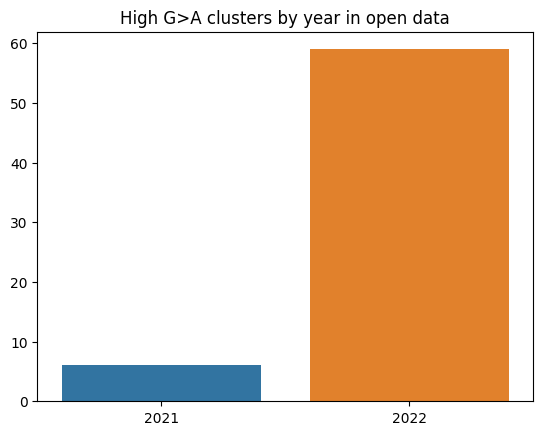

In [37]:
# draw barplot
import seaborn as sns
import matplotlib.pyplot as plt
# titl
plt.title("High G>A clusters by year in open data")
# plot
sns.barplot(x=list(year_counter.keys()), y=list(year_counter.values()))
# show
plt.show()


In [38]:
print(outputs.getvalue())

USA/NY-PV38203/2021|ON195434.1|2021-08-03 C900T,G1784A,G8219A,G10997A,G12149A,T12724C,G13379A,G18007A,A20567G,C20589T,C25366T,G25641A,G28392A,C28717T,G29260A {'C>T': 0.267, 'G>A': 0.6, 'T>C': 0.067, 'A>G': 0.067} 1.0
        USA/NY-PV38203/2021|ON195434.1|2021-08-03
England/MILK-1D4166B/2021|OU680745.1|2021-09-01 G2635A,T6409C,C6633T,G10549A,C13326T,G15202A,G18145A,A18202G,G20433A,C28265T,A29700G {'G>A': 0.455, 'T>C': 0.091, 'C>T': 0.273, 'A>G': 0.182} 1.0
        England/MILK-1D4166B/2021|OU680745.1|2021-09-01
USA/UT-UPHL-211123500296/2021|OM144063.1|2021-11-02 C193T,T3766C,G7388T,C8139T,G9257A,G11332A,T12946C,G14187A,G15451A,C19160T,C27145T {'C>T': 0.364, 'T>C': 0.182, 'G>T': 0.091, 'G>A': 0.364} 0.9090909090909091
        USA/UT-UPHL-211123500296/2021|OM144063.1|2021-11-02
VNM/OUCRU-NHTD535/2022|ON764483.1|2022-01-12 T120C,C829T,G903A,C3244T,G8939A,G12674A,C18183T,C19903T,A24049G,G26501A,C27247T,G27676A,G29468A,C29741T {'T>C': 0.071, 'C>T': 0.429, 'G>A': 0.429, 'A>G': 0.071} 1.0
   